In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
from tslearn.datasets import UCR_UEA_datasets
import sklearn
import pickle
import numpy as np 
import torch 
from TSInterpret_Artifacts.ClassificationModels.CNN_T import ResNetBaseline, UCRDataset, fit
import warnings
warnings.filterwarnings("ignore") 

from tslearn.preprocessing import TimeSeriesScalerMinMax
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

from tslearn.shapelets import LearningShapelets

In [20]:
# Plot single Time Series with Label
def plot_ts(ts_sample):
    ts= ts_sample
    plt.figure(figsize=(10, 4))
    plt.plot(ts, label="Time Series", color='blue')
    plt.title(f"Time Series")
    plt.xlabel("Time Steps")
    plt.ylabel("Value")

    # Display grid and legend
    plt.grid(False)
    # plt.legend()
    plt.show()


def scale_dataset(traindata, testdata):
    minmaxscaler = MinMaxScaler()
    minmaxscaler.fit(traindata.reshape(-1, 1))

    scaled_traindata = minmaxscaler.transform(traindata.reshape(-1, 1)).reshape(-1, 286, 1)
    scaled_testdata = minmaxscaler.transform(testdata.reshape(-1, 1)).reshape(-1, 286, 1)
    return scaled_traindata, scaled_testdata

In [21]:
dataset='Coffee'
train_x,train_y, test_x, test_y=UCR_UEA_datasets().load_dataset(dataset)


In [23]:
train_x_scaled, test_x_scaled = scale_dataset(train_x, test_x)

In [24]:
model = LearningShapelets(n_shapelets_per_size={20: 5})
model.fit(train_x_scaled, train_y)
train_distances = model.transform(train_x_scaled)
test_distances = model.transform(test_x_scaled)
shapelets = model.shapelets_

In [25]:
distances = model.transform(train_x) # Transforms each TS sample into space formed by the distances to each shapelet
predicted_locations = model.locate(train_x)

In [26]:
shap = model.shapelets_[0]
shap = TimeSeriesScalerMinMax().fit_transform(shap.reshape(1, -1, 1)).flatten()

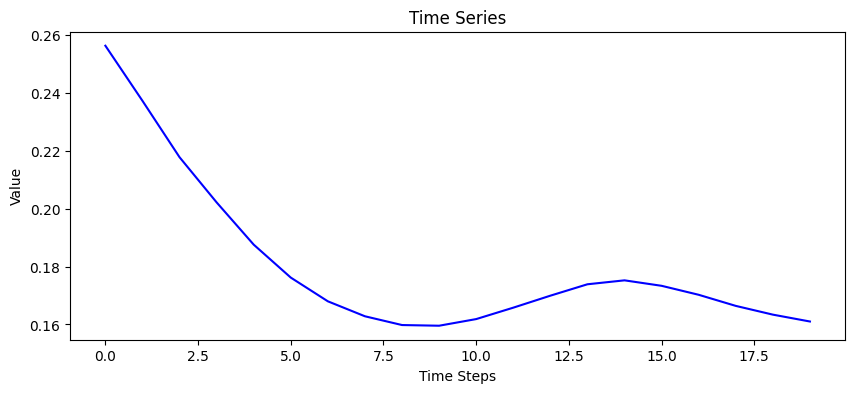

In [27]:
plot_ts(shapelets[0])

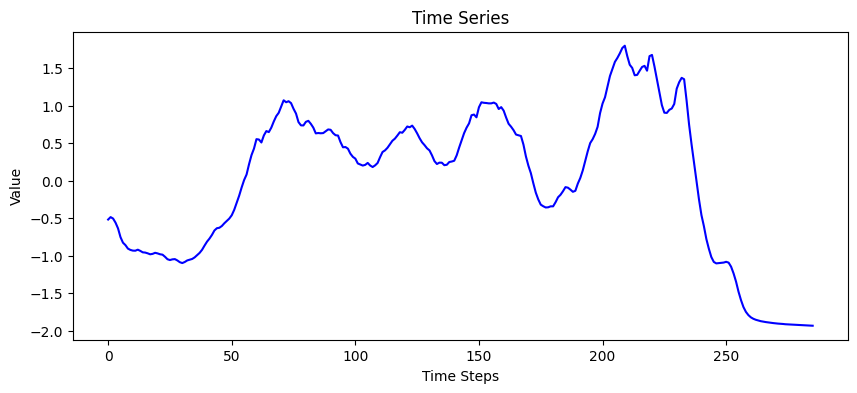

In [28]:
plot_ts(train_x[0])

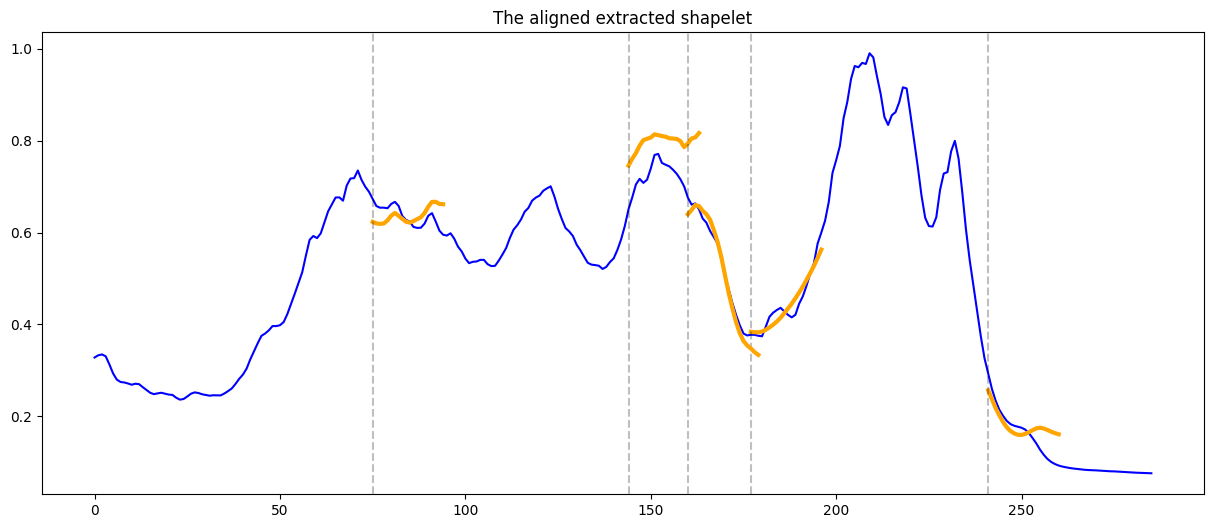

In [29]:
# 0 - 13 Label 0; 14 - 27 Label 1

distances = model.transform(train_x_scaled) # Do not use since distances come from blackbox model and are not the same as manually calculated distances
predicted_locations = model.locate(train_x_scaled)

fig, ax = plt.subplots(figsize=(15, 6))

# Plot the shapelet and align it on the best matched time series. The optimizer
# will often enlarge the shapelet to create a larger gap between the distances
# of both classes. We therefore normalize the shapelet again before plotting.

test_ts_id = 10 #np.argmin(np.sum(distances, axis=1))
id_shap = 0

ax.plot(train_x_scaled[test_ts_id].ravel(), color='blue')
for id_shap in range(len(model.shapelets_)):
    shap = model.shapelets_[id_shap]
    #shap = TimeSeriesScalerMinMax().fit_transform(shap.reshape(1, -1, 1)).flatten()
    pos = predicted_locations[test_ts_id, id_shap]
    ax.plot(np.arange(pos, pos + len(shap)), shap, linewidth=3, color='orange')
    ax.axvline(pos, color='k', linestyle='--', alpha=0.25)
    ax.set_title("The aligned extracted shapelet")

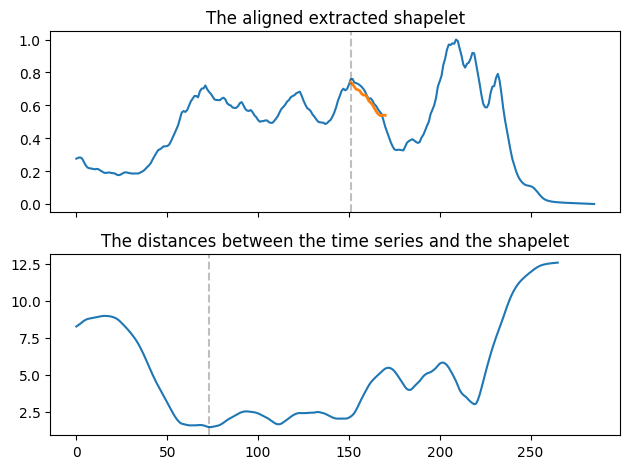

In [15]:
# 0 - 13 Label 0; 14 - 27 Label 1

distances = model.transform(train_x_scaled) # Do not use since distances come from blackbox model and are not the same as manually calculated distances
predicted_locations = model.locate(train_x_scaled)

f, ax = plt.subplots(2, 1, sharex=True)

# Plot the shapelet and align it on the best matched time series. The optimizer
# will often enlarge the shapelet to create a larger gap between the distances
# of both classes. We therefore normalize the shapelet again before plotting.

test_ts_id = 10 #np.argmin(np.sum(distances, axis=1))
id_shap = 1

shap = model.shapelets_[id_shap]
#shap = TimeSeriesScalerMinMax().fit_transform(shap.reshape(1, -1, 1)).flatten()
pos = predicted_locations[test_ts_id, id_shap]
ax[0].plot(train_x_scaled[test_ts_id].ravel())
ax[0].plot(np.arange(pos, pos + len(shap)), shap, linewidth=2)
ax[0].axvline(pos, color='k', linestyle='--', alpha=0.25)
ax[0].set_title("The aligned extracted shapelet")

# We calculate the distances from the shapelet to the timeseries ourselves.
distances_man = []
time_series = train_x_scaled[test_ts_id].ravel()
for i in range(len(time_series) - len(shap)):
    distances_man.append(np.linalg.norm(time_series[i:i+len(shap)] - shap)) # Dynamic Time Warping als Distanzmetrik
ax[1].plot(distances_man)
ax[1].axvline(np.argmin(distances_man), color='k', linestyle='--', alpha=0.25)
ax[1].set_title('The distances between the time series and the shapelet')

plt.tight_layout()
plt.show()

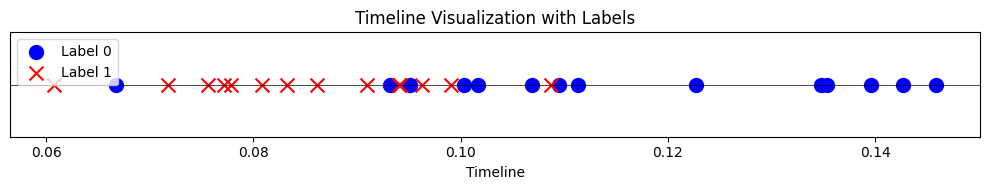

In [56]:
data = train_distances.flatten()
labels = train_y

# Marker styles for labels
marker_styles = {0: 'o', 1: 'x'}
colors = {0: 'blue', 1: 'red'}

# Create the figure and axis
plt.figure(figsize=(10, 2))
plt.axhline(0, color='black', linewidth=0.5)  # Timeline baseline

# Plot points on the timeline
for dist, label in zip(data, labels):
    plt.scatter(dist, 0, marker=marker_styles[label], color=colors[label], s=100, label=f'Label {label}')

# Remove duplicate legend entries
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper left')

# Add annotations for each point
# for number in data:
#     plt.text(number, 0.1, str(number), ha='center', va='bottom', fontsize=9)

# Adjust timeline aesthetics
plt.yticks([])  # Remove y-axis ticks
plt.xlabel('Timeline')
plt.title('Timeline Visualization with Labels')
plt.tight_layout()
plt.show()

In [55]:
np.argmin(distances_man)

85

In [44]:
distances[85]

10.93835248102729

In [49]:
distances[88:][79]

11.289543607112282

In [53]:
distances_man[167]

11.289543607112282